# engine

> Fill in a module description here

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp engine

In [ ]:
#| hide
#| export
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline

In [ ]:
#| hide
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*')
        return out
    
    def __repr__(self):
        return f'Value(data={self.data})'

In [ ]:
a = Value(2., label='a')
a

Value(data=2.0)

In [ ]:
b = Value(-3, label='b')
a+b

Value(data=-1.0)

In [ ]:
c = Value(10., label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
f = Value(-2.); f.label='f'
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
#|hide

# manual gradients
L.grad=1
f.grad=d.data
d.grad=f.data
c.grad = d.grad
e.grad = d.grad
b.grad=e.grad * a.data
a.grad=e.grad * b.data

# nudge leaf nodes that we control
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass to evaluate L
e = a*b
d = e + c
L = d*f
L

Value(data=-7.286496)

#|hide

Hooray, $L$ increased from $-8$ to $-7.28$!

#|hide

Example 2: Backpropogating through a neuron

* bias $b$ is the "innate trigger happiness" of the neuron

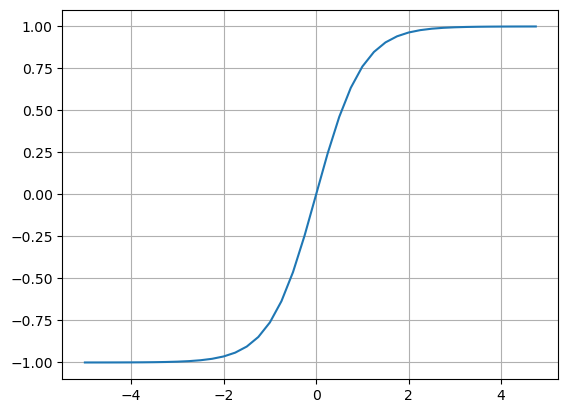

In [ ]:
#|hide
# A squashing function (a.k.a as an activation function)
xs = np.arange(-5,5,0.25)
ys = np.tanh(xs)
plt.plot(xs, ys); plt.grid()

#|hide

Now $\tanh(x) = \frac{e^{2x}+1}{e^{2x}+1}$ so at this point we will update our `Value` so we can do exponentiation and division.

In [ ]:
#| export
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation (+,-,* or tanh) that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1.)/(math.exp(2*x)+1.)
        out = Value(t,(self,),'tanh',)
        return out
    
    def __repr__(self):
        return f'Value(data={self.data})'

In [ ]:
#|hide
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'

o= n.tanh(); o.label='o'

In [ ]:
from neev.viz import *

$\frac{\partial o}{\partial o} = 1$

In [ ]:
o.grad = 1 #do_do = 1

$\frac{\partial o}{\partial n} = \frac{\partial \tanh(n)}{\partial n} = 1-\tanh(n)^2 = 1 - o^2$

In [ ]:
n.grad =  1 - (o.data**2)

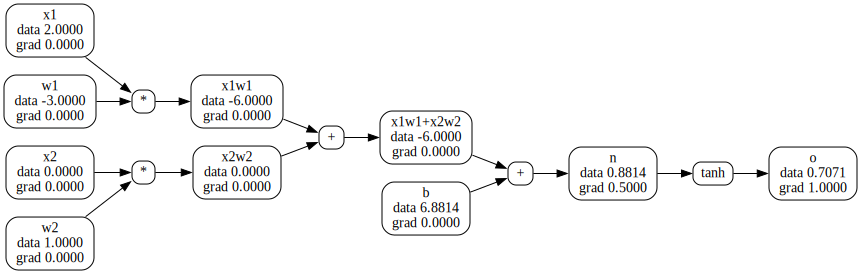

In [ ]:
view_dot(o)

Recall that the plus (+) operator acts as a distributor of gradients so it will just flow the back the incoming gradient to it's children nodes. It's helpful to think of the gradient as flowing from the left to the right.

In [ ]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

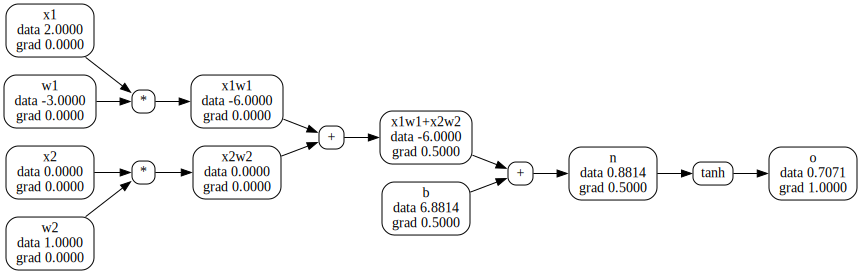

In [ ]:
view_dot(o)

Next we encounter the + operator again so we distribute the incoming $0.5$ to botg $x1w1$ and $x2w2$.

In [ ]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

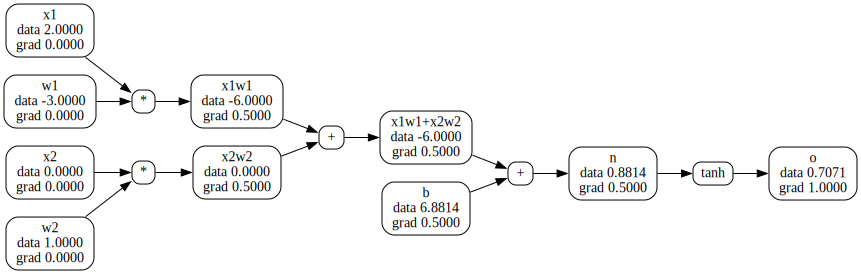

In [ ]:
view_dot(o)

For the * operator for $x1w1$ we know that $x1$'s local grad will be $w1$'s data. So,

In [ ]:
x1.grad = w1.data*x1w1.grad

In [ ]:
w1.grad = x1.data*x1w1.grad

In [ ]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

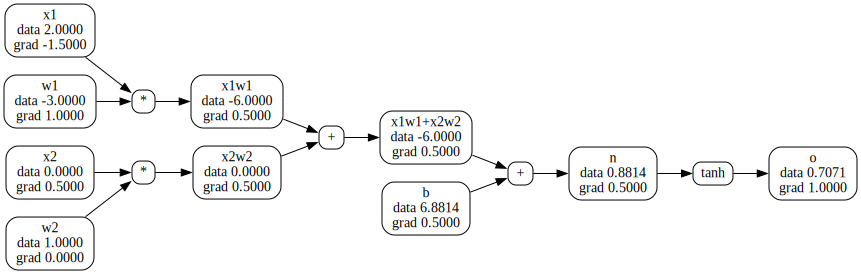

In [ ]:
view_dot(o)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()